<b><h1 style="text-align:center;">COMM493 - Coding AI for Business</h1></b>
<h5 style="text-align:center;">K-MEANS CLUSTERING FOR GYM MEMBERSHIP CUSTOMERS</h5>
<h5 style="text-align:center;">INSERT NAMES HERE</h5>
<h5 style="text-align:center;">March 31st, 2025</h5>

### Introduction
**Motivation:** TODO

**Data:** <a href="https://www.kaggle.com/datasets/ka66ledata/gym-membership-dataset/data">gym-membership-dataset</a> 

**Goal:** TODO

### 0: Set Up Environment
Load imports and define constants that will be used to prepare data and train model.

In [1]:
# install mxnet
get_ipython().system('pip install mxnet')

# suppress warnings
import warnings
warnings.filterwarnings('ignore')

# AWS SageMaker and Boto3
import sagemaker
from sagemaker import get_execution_role, KMeans
from sagemaker.image_uris import retrieve
import boto3
from botocore.exceptions import ClientError
from sagemaker.model import Model
from sagemaker.predictor import Predictor
from sagemaker.serializers import CSVSerializer

# Data Manipulation
import pandas as pd
import numpy as np
np.bool = bool

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# Machine Learning
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.decomposition import PCA

# Additional Libraries
import tarfile
import mxnet as mx
import time
import json

[03/27/25 21:52:19] INFO     Found credentials from IAM Role:                                   ]8;id=707290;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=38630;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


### 1: SageMaker Setup & Configuration

In [2]:
# Initialize a SageMaker Session
sagemaker_session = sagemaker.Session()
role = get_execution_role()
region = sagemaker_session.boto_region_name
s3_client = boto3.client('s3')
sagemaker_client = boto3.client('sagemaker')
image_uri = retrieve('kmeans', region)
bucket = sagemaker_session.default_bucket()
prefix = 'sagemaker/gym/kmeans'
print("Execution Role ARN:", role)
print("AWS Region:", region)

[03/27/25 21:52:21] INFO     Found credentials from IAM Role:                                   ]8;id=542282;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=379840;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

                    INFO     Found credentials from IAM Role:                                   ]8;id=427176;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=960345;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

                    INFO     Found credentials from IAM Role:                                   ]8;id=413299;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=822915;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

                    INFO     Same images used for training and inference. Defaulting to image     ]8;id=41312;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=501772;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

[03/27/25 21:52:22] INFO     Ignoring unnecessary instance type: None.                            ]8;id=397482;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=440498;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

Execution Role ARN: arn:aws:iam::922202922528:role/LabRole
AWS Region: us-east-1


### 2: Helper Functions

Define several functions that will be used to help in preprocessing the data, plotting scatterplots to gain an understanding of how the data and clusters will look like, and the creation of endpoints to be called for examples. 

In [3]:
# define scaler
scaler = StandardScaler()

def time_to_minutes(time_str):
    """Convert time in HH:MM:SS format to minutes."""
    if pd.isna(time_str):
        return 0
    try:
        h, m, s = map(int, time_str.split(':'))
        return h * 60 + m
    except ValueError:
        return 0


def plot_3D(data, labels=None, centroids=None, title=""):
    """Visualize clusters in 3D space with labeled centroids."""
    # unscale data for visualization
    data = scaler.inverse_transform(data)
    if centroids is not None:
        centroids = scaler.inverse_transform(centroids)

    # handle no clustering case
    is_clustered = True
    if (labels is None) or (centroids is None):
        labels = np.zeros(len(data), dtype=int)  # All points in cluster 0
        centroids = np.mean(data, axis=0).reshape(1, -1)  # Global mean as centroid
        title = "3D Visualization"
        is_clustered = False

    # Create figure
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Get unique cluster labels and define colors
    unique_labels = np.unique(labels)
    colors = plt.cm.viridis(np.linspace(0, 1, len(unique_labels)))

    # Plot each cluster with its respective color
    for i, label in enumerate(unique_labels):
        idx = labels == label
        ax.scatter(data[idx, 0], data[idx, 1], data[idx, 2],
                   color=colors[i], label=f'Cluster {label}', s=50, alpha=0.6)

    # Plot centroids separately with labels
    ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2],
               color='red', marker='X', s=200, edgecolor='black', 
               linewidth=1.5, label='Centroids')

    if is_clustered:
        ax.set_title(f'{title}\nSilhouette Score: {silhouette_score(data, labels):.3f}')
    else:
        ax.set_title(title)
    ax.set_xlabel('Age')
    ax.set_ylabel('Avg Check-In Time')
    ax.set_zlabel('Spending Score')
    ax.legend(title="Clusters", loc="upper right")
    plt.tight_layout()
    plt.show()


def wait_for_endpoint_config_deletion(endpoint_config_name):
    '''Function to wait for endpoint configuration deletion'''
    print(f'Waiting for endpoint configuration "{endpoint_config_name}" to be deleted...')
    while True:
        try:
            sagemaker_client.describe_endpoint_config(EndpointConfigName=endpoint_config_name)
            time.sleep(5)  # Poll every 5 seconds
        except ClientError as e:
            if e.response['Error']['Code'] == 'ValidationException':
                print(f'Endpoint configuration "{endpoint_config_name}" deleted.')
                break
            else:
                raise


def wait_for_endpoint_deletion(endpoint_name):
    '''Function to wait for endpoint deletion'''
    print(f'Waiting for endpoint "{endpoint_name}" to be deleted...')
    while True:
        try:
            sagemaker_client.describe_endpoint(EndpointName=endpoint_name)
            time.sleep(5)  # Poll every 5 seconds
        except ClientError as e:
            if e.response['Error']['Code'] == 'ValidationException':
                print(f'Endpoint "{endpoint_name}" deleted.')
                break
            else:
                raise


def delete_endpoint_config(endpoint_config_name):
    '''Function for endpoint config deletion'''
    try:
        sagemaker_client.describe_endpoint_config(EndpointConfigName=endpoint_config_name)
        print(f'Endpoint configuration "{endpoint_config_name}" exists. Deleting...')
        sagemaker_client.delete_endpoint_config(EndpointConfigName=endpoint_config_name)
        print(f'Endpoint configuration "{endpoint_config_name}" deleted successfully.')
    except ClientError as e:
        if e.response['Error']['Code'] == 'ValidationException':
            print(f'Endpoint configuration "{endpoint_config_name}" does not exist.')
        else:
            raise


def delete_endpoint(endpoint_name):
    '''Function for endpoint deletion'''
    try:
        sagemaker_client.describe_endpoint(EndpointName=endpoint_name)
        print(f'Endpoint "{endpoint_name}" exists. Deleting...')
        sagemaker_client.delete_endpoint(EndpointName=endpoint_name)
        print(f'Endpoint "{endpoint_name}" deleted successfully.')
    except ClientError as e:
        if e.response['Error']['Code'] == 'ValidationException':
            print(f'Endpoint "{endpoint_name}" does not exist.')
        else:
            raise

### 3: Load and Process Data

Categorical data is not optimal for k-means clustering. This is because clustering algorithms mainly rely on Euclidean distance (the straight-line distance between points). For example, categorical variables like "Male" vs "Female" do not have a natural numerical representation and will lead to "meaningless" or arbitrary distances. For example, if we assign "Red", "Blue", "Green" as 1,2,3, k-means might assume Green (3) is closer to Blue (2) than Red (1), which is not necessarily true. Similarly, One-hot encoding is a common approach to handle categorical data, however this can lead to a huge increase in the number of columns and dilate meaningful patterns. 

To solve this, we created a "profitability score" for each gym member as a new column. This will be represented as a number and calculated using the different features of a gym members habits, taking into consideration that specific features will carry more weight than others in terms of profitability (e.g. owning a "Premium" subscription would be considered to have a high profitability compared to how often a member purchases a beverage)

Processed Data Preview:
Shape: (1000, 3)
NaN values: 0
Columns: ['Age', 'avg_time_check_in', 'score']
   Age  avg_time_check_in  score
0   27               1171  62.65
1   47               1171   2.76
2   41                509  47.92
3   44                594  51.24
4   44                509  24.95


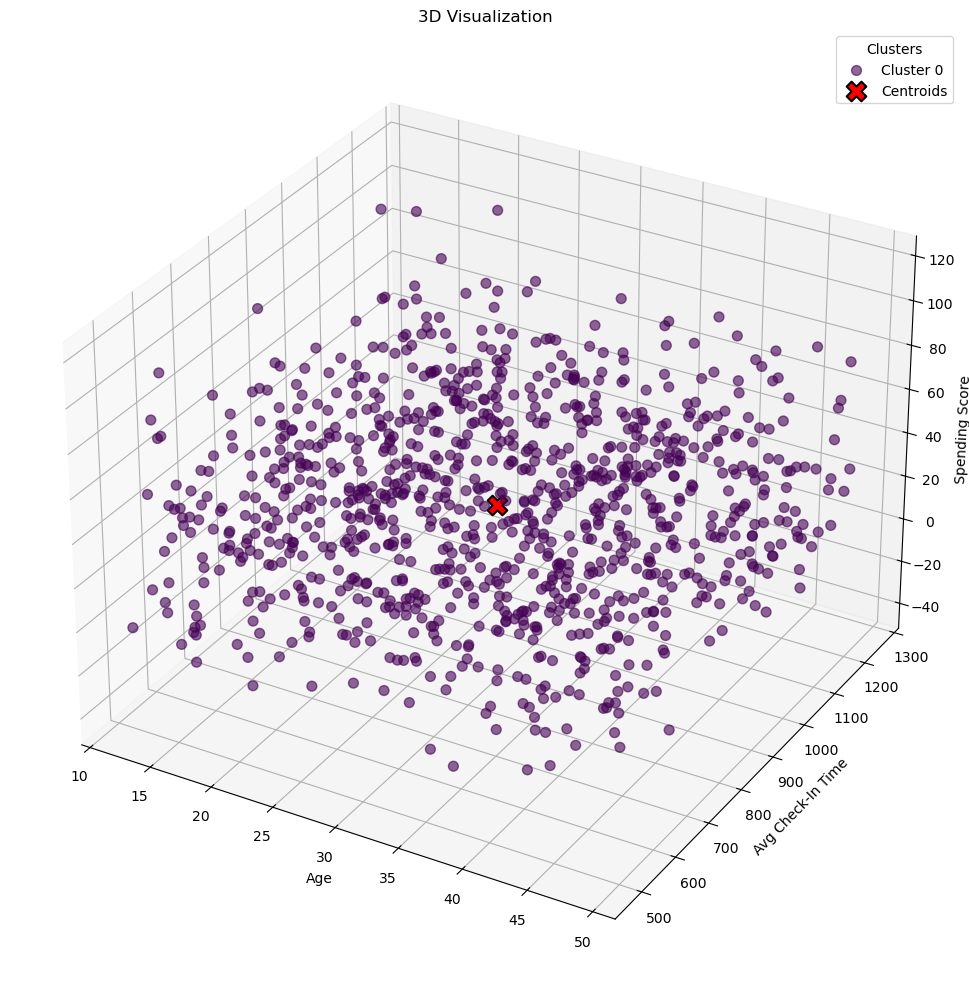

In [4]:
# Load data
df = pd.read_csv('gym_membership.csv')

# Drop irrelevant columns
df.drop(columns=[
    'id', 'birthday', 'name_personal_trainer',
    'gender', 'days_per_week', 'avg_time_check_out'
], inplace=True)

# convert time to minues
df['avg_time_check_in'] = df['avg_time_check_in'].apply(time_to_minutes)

# convert catagorical list into count
df['fav_drink'] = df['fav_drink'].fillna('').apply(
    lambda x: len(x.split(', ')) if x != '' else 0
)
df['fav_group_lesson'] = df['fav_group_lesson'].fillna('').apply(
    lambda x: len(x.split(', ')) if x != '' else 0
)

# create profitability score for each customer
weights = {
    'premium': 1.8,        # Premium subscriptions = highest margin
    'training': 2.2,       # Personal training = high margin service
    'drink_abo': 1.5,      # Recurring drink revenue
    'group_lessons': 1.5,  # Potential class package upsells
    'sauna': 1.0,          # Low margin facility usage
    'visits': 1.8,         # More visits indicate loyalty
    'gym_time': 0.7,       # Duration less important than purchases
    'fav_drinks': 0.6,     # Drink preferences hint at upsell potential
    'fav_classes': 1.0     # Class preferences indicate package interest
}

# standardize values
to_standardize = ['visit_per_week', 'avg_time_in_gym', 'fav_drink', 'fav_group_lesson']
df[to_standardize] = scaler.fit_transform(df[to_standardize])

# create score
df['score'] = (
    df['visit_per_week'] * weights['visits'] +
    df['uses_sauna'].astype(int) * weights['sauna'] +
    df['personal_training'].astype(int) * weights['training'] +
    df['attend_group_lesson'].astype(int) * weights['group_lessons'] +
    (df['abonoment_type'] == 'Premium').astype(int) * weights['premium'] +
    df['drink_abo'].astype(int) * weights['drink_abo'] +
    df['avg_time_in_gym'] * weights['gym_time'] +
    df['fav_drink'] * weights['fav_drinks'] +
    df['fav_group_lesson'] * weights['fav_classes']
)
# standardize values
df['score'] = (df['score'] / sum(weights.values()) * 100).round(2)

# drop columns that were used for score calculation
df.drop(columns=to_standardize, inplace=True)
df.drop(columns=[
    'uses_sauna', 'personal_training',
    'attend_group_lesson', 'abonoment_type', 'drink_abo'
], inplace=True)

# print info
print("Processed Data Preview:")
print(f"Shape: {df.shape}")
print(f"NaN values: {df.isna().sum().sum()}")
print(f"Columns: {df.columns.tolist()}")
print(df.head())

# standardize data for better results
data_np = scaler.fit_transform(df).astype('float32')

# preview
plot_3D(data_np)

### 4: Perform k-Means Clustering (k=3,4,...,6)

Here we perform our K-means clustering training. We are going to creating training job based on a range (3 to 8) of possible clusters our data can be split into. Once we have a training job for each value of K, we can perform different evaluations to determine which number of clusters will give us the best results.

In [5]:
k_values = range(3, 7)
training_jobs = []
output_path = f's3://{bucket}/output'

# start training jobs
for k in k_values:
    kmeans = KMeans(
        sagemaker_session=sagemaker_session,
        role=role,
        instance_count=1,
        instance_type='ml.m5.xlarge',
        k=k,
        output_path=output_path,
        feature_dim=data_np.shape[1],
        extra_hyperparameters={
            'kmeans_init_method': 'kmeans++',
            'epochs': 2,
            'mini_batch_size': 32,
            'extra_center_factor': 5  # disperse during initialization
        }
    )
    kmeans.fit(kmeans.record_set(data_np), wait=False)
    training_jobs.append((k, kmeans.latest_training_job.name))

# Wait for all jobs to complete
for k, job_name in training_jobs:
    boto3.client('sagemaker').get_waiter('training_job_completed_or_stopped').wait(
        TrainingJobName=job_name)

                    INFO     Same images used for training and inference. Defaulting to image     ]8;id=363155;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=982883;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

[03/27/25 21:52:23] INFO     Ignoring unnecessary instance type: None.                            ]8;id=506296;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=865844;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Same images used for training and inference. Defaulting to image     ]8;id=279583;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=123433;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=971611;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=431032;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Creating training-job with name: kmeans-2025-03-27-21-52-23-022        ]8;id=217098;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=346009;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#1042\1042]8;;\

                    INFO     Same images used for training and inference. Defaulting to image     ]8;id=790656;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=121572;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=609099;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=142858;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Same images used for training and inference. Defaulting to image     ]8;id=168110;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=112781;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=969351;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=145177;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Creating training-job with name: kmeans-2025-03-27-21-52-23-607        ]8;id=844684;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=633612;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#1042\1042]8;;\

[03/27/25 21:52:24] INFO     Same images used for training and inference. Defaulting to image     ]8;id=905980;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=965395;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=103012;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=224219;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Same images used for training and inference. Defaulting to image     ]8;id=938008;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=282820;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=330725;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=700492;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Creating training-job with name: kmeans-2025-03-27-21-52-24-936        ]8;id=187111;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=389238;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#1042\1042]8;;\

[03/27/25 21:52:25] INFO     Same images used for training and inference. Defaulting to image     ]8;id=47389;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=741914;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=961059;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=841539;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Same images used for training and inference. Defaulting to image     ]8;id=355851;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=936301;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=727390;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=889721;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Creating training-job with name: kmeans-2025-03-27-21-52-25-828        ]8;id=766474;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=617585;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#1042\1042]8;;\

### 5: Select Best K Value With Sum of Squared Error (SSE) & Silhouette Score

Now that we have all the training jobs for various values of K, we are going to perform two evaluations to determine the optimal K value: Sum of Squared Error (SSE) and Silhouette Score.

Relating back to our business object, this will determine the number of packages the gym should offer to optimize profit based on their gym members tendencies. 

#### Evaluation Results
Looking at the Elbow Method Analysis, we want to identify the point where the rate of decrease stops dropping as rapidly, indicating that adding more clusters beyond this point yields diminishing returns. Looking at the graph, it is difficult to tell where is the point where the rate of decrease changes significantly as we have multiple points that could be the case. We can estimate 4 as the point but we will move onto the Silhouette Score Analysis for a clearer result.

Looking at the Silhouette Score Analysis, we want to find the point that is closest to the value 1, as a score of 1 represents that all the data points are well within its cluster and far from other clusters. Our results show that 6 is the optimal number of clusters. In terms of our business object, this means that based on the tendency of gym members at this gym, the gym can make the most profit by offering 6 types of packages. 

Looking at the scatterplot, we are able to identify that the 6 clusters we can fit an individual into given a certain age, average check-in time, and profitability score based on their gym habits. Using these clusters, we are able to identify what membership a person would fit into best to maximize their benefits while also provide the gym with the optimal profit. 

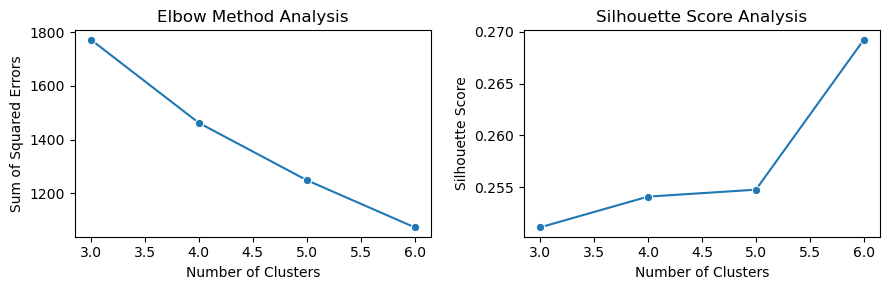

Optimal number of clusters: 6 (Silhouette Score: 0.269)


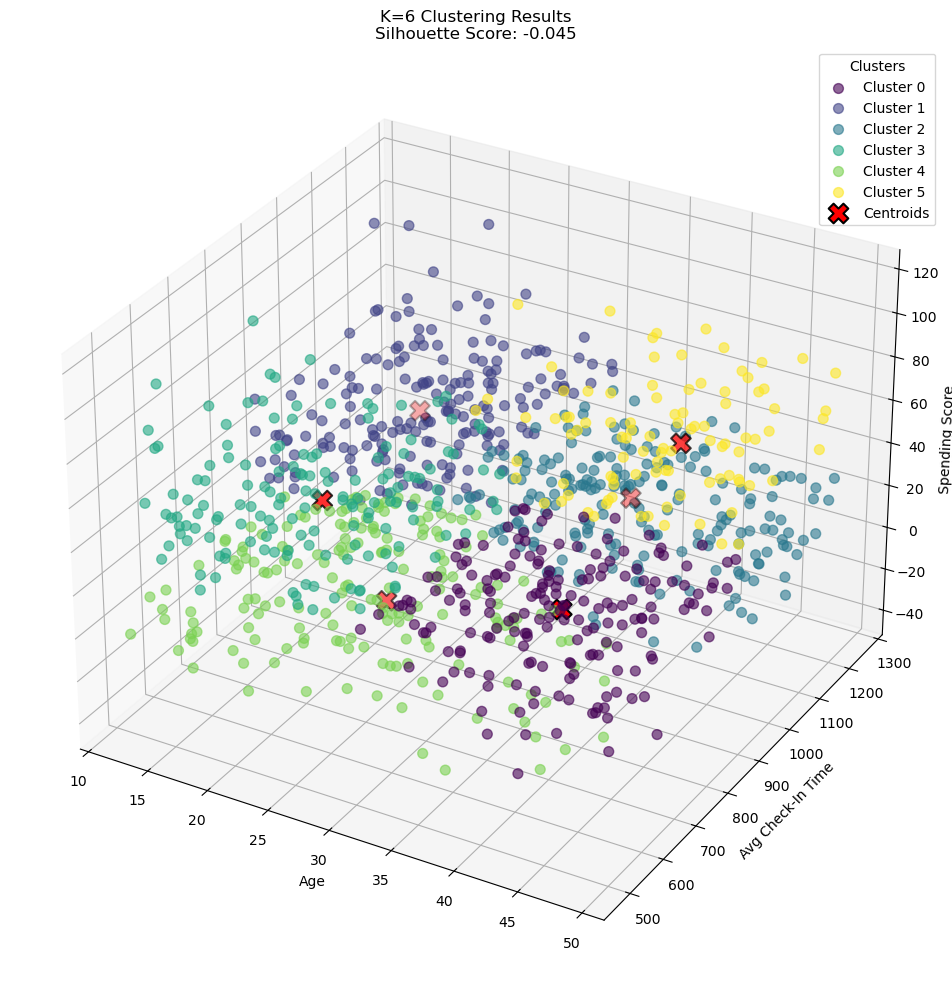

In [6]:
sse_values = []
silhouette_scores = []
results = {}

for k, job_name in training_jobs:
    try:
        # Retrieve model artifacts
        job_desc = sagemaker_client.describe_training_job(TrainingJobName=job_name)
        model_path = job_desc['ModelArtifacts']['S3ModelArtifacts']

        # Download and extract model
        local_path = f'/tmp/model-k-{k}.tar.gz'
        boto3.client('s3').download_file(bucket, model_path.replace(f's3://{bucket}/', ''), local_path)
        with tarfile.open(local_path) as tar:
            tar.extractall(path=f'/tmp/k-{k}')

        # Load model parameters
        model_params = mx.ndarray.load(f'/tmp/k-{k}/model_algo-1')
        centroids = model_params[0].asnumpy()

        # Calculate cluster assignments
        distances = np.linalg.norm(data_np[:, np.newaxis] - centroids, axis=2)
        labels = np.argmin(distances, axis=1)

        # Calculate metrics
        sse = np.sum((data_np - centroids[labels])**2)
        sil_score = silhouette_score(data_np, labels)
        sse_values.append(sse)
        silhouette_scores.append(sil_score)

        # Plot results for each k
        results[k] = (labels, centroids)
        # plot_3D(data_np, labels, centroids, f'K={k} Clustering Results')

    except Exception as e:
        print(f'Error processing K={k}: {str(e)}')

# Plot evaluation metrics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 3))
sns.lineplot(x=k_values, y=sse_values, marker='o', ax=ax1)
ax1.set_title('Elbow Method Analysis')
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('Sum of Squared Errors')

sns.lineplot(x=k_values, y=silhouette_scores, marker='o', ax=ax2)
ax2.set_title('Silhouette Score Analysis')
ax2.set_xlabel('Number of Clusters')
ax2.set_ylabel('Silhouette Score')
plt.tight_layout()
plt.show()

# Select optimal K
best_k = k_values[np.argmax(silhouette_scores)]
best_job_name = training_jobs[np.argmax(silhouette_scores)][1]
print(f'Optimal number of clusters: {best_k} (Silhouette Score: {max(silhouette_scores):.3f})')

plot_3D(data_np, results[best_k][0], results[best_k][1], f'K={best_k} Clustering Results')

### 6: Model Deployment to SageMaker Endpoint

Deploying a real-time endpoint to group an individual into a group that reflects their ideal gym membership package.

In [7]:
# Specify names for the endpoint and its configuration
endpoint_name = 'gym-kmeans'
endpoint_config_name = 'gym-kmeans'

# Check and delete the existing endpoint configuration if it exists
try:
    sagemaker_client.describe_endpoint_config(EndpointConfigName=endpoint_config_name)
    print(f'Endpoint configuration "{endpoint_config_name}" already exists. Deleting...')
    sagemaker_client.delete_endpoint_config(EndpointConfigName=endpoint_config_name)
    wait_for_endpoint_config_deletion(endpoint_config_name)
except ClientError as e:
    if e.response['Error']['Code'] == 'ValidationException':
        print(f'Endpoint configuration "{endpoint_config_name}" does not exist.')

# Check and delete the existing endpoint if it exists
try:
    sagemaker_client.describe_endpoint(EndpointName=endpoint_name)
    print(f'Endpoint "{endpoint_name}" already exists. Deleting...')
    sagemaker_client.delete_endpoint(EndpointName=endpoint_name)
    wait_for_endpoint_deletion(endpoint_name)
except ClientError as e:
    if e.response['Error']['Code'] == 'ValidationException':
        print(f'Endpoint "{endpoint_name}" does not exist.')

# Identify the best model based on prior analysis
job_desc = sagemaker_client.describe_training_job(TrainingJobName=best_job_name)
best_model_s3_uri = job_desc['ModelArtifacts']['S3ModelArtifacts']

# Create a SageMaker Model object with the best model's artifacts
best_model = Model(
    model_data=best_model_s3_uri,
    image_uri=image_uri,
    role=role,
    sagemaker_session=sagemaker_session
)

# Deploy the model to an endpoint
predictor = best_model.deploy(
    endpoint_name=endpoint_name,
    initial_instance_count=1,
    instance_type='ml.m5.large',
    wait=True
)

predictor = Predictor(endpoint_name=endpoint_name, serializer=CSVSerializer())
print(f'Model deployed to endpoint: {endpoint_name}')

Endpoint configuration "gym-kmeans" already exists. Deleting...
Waiting for endpoint configuration "gym-kmeans" to be deleted...
Endpoint configuration "gym-kmeans" deleted.
Endpoint "gym-kmeans" already exists. Deleting...
Waiting for endpoint "gym-kmeans" to be deleted...
Endpoint "gym-kmeans" deleted.


[03/27/25 21:56:35] INFO     Creating model with name: kmeans-2025-03-27-21-56-35-182               ]8;id=612017;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=541932;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4094\4094]8;;\

                    INFO     Creating endpoint-config with name gym-kmeans                          ]8;id=177693;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=954530;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#5937\5937]8;;\

                    INFO     Creating endpoint with name gym-kmeans                                 ]8;id=466502;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=401828;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4759\4759]8;;\

-------!Model deployed to endpoint: gym-kmeans


### Query Model With Sample Data

Here we will demonstrate how the model predicts which group to put an individual by generating an example gym member of the age 50, average check in at 8AM, and a profitability score of 66. 

Relating back to the business context, a gym can integrate this by gathering information about a new gym member. The gym staff can ask the new member for:
- Age
- When they usually come to the gym (average gym check-in)
- How long their usual gym session is
- If they're looking for personal training or group sessions
- If they have any classes they're interested in
- How important amenities are to them (i.e. sauna, access to drinks)
Using this information, they can send it to the model endpoint and instantly get the optimal gym package in real-time.

In [8]:
# create sample data
print("Creating predictin for gym member of age 50, average check in at 8am, with a profitability score of 66")
new_data = np.array([[50, 480 , 66]])

# applies the previously fitted StandardScaler transformation to new_data
new_data = scaler.transform(new_data)

# Parse the prediction response
response = predictor.predict(new_data)
response_json = json.loads(response)
cluster = response_json['predictions'][0]['closest_cluster']
distance = response_json['predictions'][0]['distance_to_cluster']

# Print the cluster assignment
print(f"The data point belongs to Cluster {int(cluster)} with a distance of {distance:.2f} to the cluster center.")

Creating predictin for gym member of age 50, average check in at 8am, with a profitability score of 66
The data point belongs to Cluster 0 with a distance of 1.60 to the cluster center.


### Delete the Endpoint and Endpoint Config

In [9]:
# Delete the endpoint configuration
delete_endpoint_config(endpoint_config_name)
# Delete the endpoint
delete_endpoint(endpoint_name)

Endpoint configuration "gym-kmeans" exists. Deleting...
Endpoint configuration "gym-kmeans" deleted successfully.
Endpoint "gym-kmeans" exists. Deleting...
Endpoint "gym-kmeans" deleted successfully.
